# CEC Benchmarks

Run 1/3
Enhanced SRA is optimizing "f1"
Run 2/3
Enhanced SRA is optimizing "f1"
Run 3/3
Enhanced SRA is optimizing "f1"


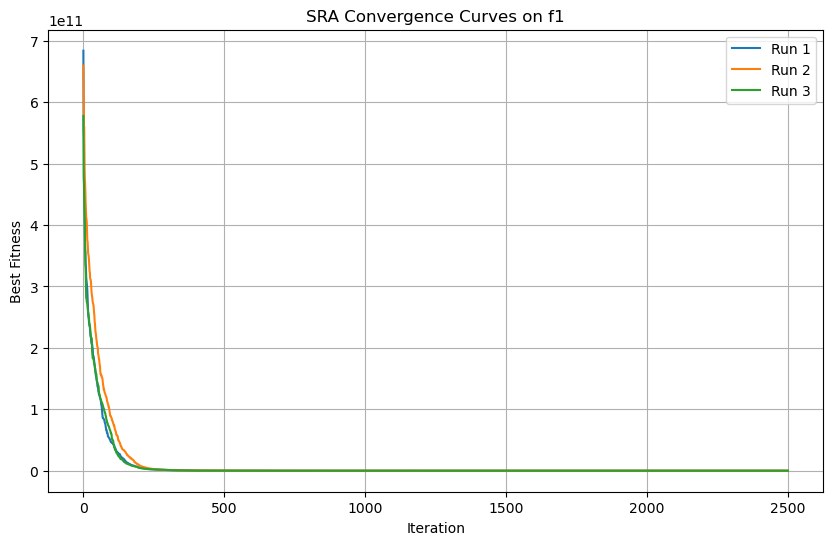

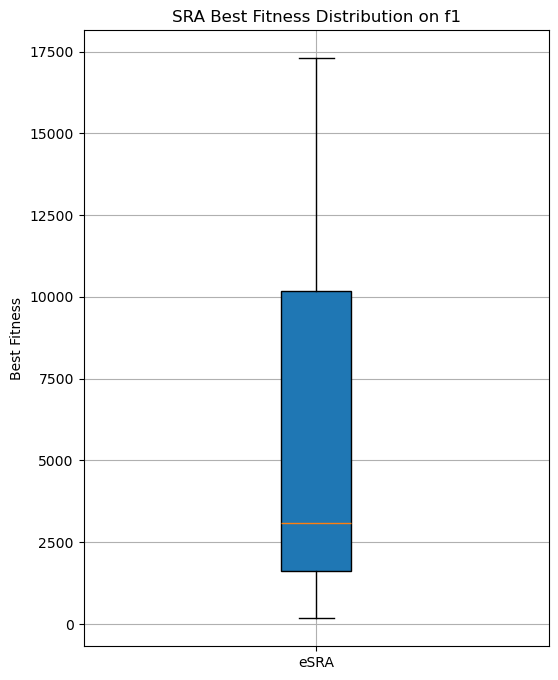

Best fitness values across 3 runs: [17298.131701368646, 173.87261267946232, 3092.557473976188]
Mean best fitness: 6854.8539293414315
Standard deviation of best fitness: 7480.027553321754


In [3]:
import random
import numpy
import math
import time
import opfunu
import pytest
from numpy import abs, zeros, log10, where, arctanh, tanh
from numpy.random import uniform, standard_cauchy
import matplotlib.pyplot as plt
# import opfunu.cec_based.F12022

class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

import random
import numpy
import math
import time
from numpy import abs, zeros, log10, where, arctanh, tanh
from numpy.random import uniform, standard_cauchy

def eSRA(objf, lb, ub, dim, PopSize, iters, function_name):
    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    lb = numpy.array(lb)
    ub = numpy.array(ub) 
    
    # Enhanced parameters
    L = 0.5
    h = 6.625e-34
    Cost = numpy.full(PopSize, float("inf"))
    pos = numpy.zeros((PopSize, dim))
    Psai = numpy.zeros((PopSize, dim))
    velocity = numpy.zeros((PopSize, dim))  # Add velocity for better movement
    stagnation_counter = numpy.zeros(PopSize)  # Track stagnation
    
    # Elite population tracking
    elite_size = max(3, PopSize // 10)
    elite_pos = numpy.zeros((elite_size, dim))
    elite_cost = numpy.full(elite_size, float("inf"))
    
    # Initialize population with enhanced diversity
    for i in range(dim):
        # Use opposition-based learning for better initial diversity
        rand_pos = numpy.random.uniform(0, 1, PopSize // 2)
        opp_pos = 1 - rand_pos  # Opposition-based positions
        combined_pos = numpy.concatenate([rand_pos, opp_pos[:PopSize - PopSize // 2]])
        pos[:, i] = combined_pos * (ub[i] - lb[i]) + lb[i]
    
    # Initialize Psai and evaluate fitness
    for i in range(PopSize):
        for j in range(dim):
            pos[i, j] = numpy.clip(pos[i, j], lb[j], ub[j])
            Psai[i, j] = math.sqrt(2/L) * numpy.sin(pos[i, j]) * numpy.exp(2)
        Cost[i] = objf.evaluate(pos[i, :])
    
    # Sort and get best solutions
    SmellOrder = numpy.sort(Cost)
    SmellIndex = numpy.argsort(Cost)
    Best_Cost = SmellOrder[0]
    sorted_population = pos[SmellIndex, :]
    Best_X = sorted_population[0, :].copy()
    
    # Initialize elite population
    for i in range(min(elite_size, PopSize)):
        elite_pos[i] = sorted_population[i].copy()
        elite_cost[i] = SmellOrder[i]
    
    convergence_curve = numpy.zeros(iters)
    s = solution()
    print(f'Enhanced SRA is optimizing "{function_name}"')
    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    
    # Adaptive parameters
    no_improvement_count = 0
    best_cost_history = []
    
    for l in range(iters):
        # Adaptive convergence factor with multiple strategies
        b = 1 - (l / iters) ** 0.5  # Square root decay for smoother transition
        
        # Dynamic mutation probability
        mutation_prob = 0.03 * (1 + math.cos(math.pi * l / iters)) / 2
        
        # Update sorting
        SmellOrder = numpy.sort(Cost)  
        SmellIndex = numpy.argsort(Cost)
        sorted_population = pos[SmellIndex, :]
        sorted_Psai = Psai[SmellIndex, :]
        Best_Psai = sorted_Psai[0, :]
        Worst_Psai = sorted_Psai[PopSize-1, :]
        
        # Track improvement
        if SmellOrder[0] < Best_Cost:
            Best_Cost = SmellOrder[0]
            Best_X = sorted_population[0, :].copy()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        best_cost_history.append(Best_Cost)
        
        # Update elite population
        for i in range(PopSize):
            if Cost[i] < elite_cost[-1]:
                # Insert new elite member
                elite_pos[-1] = pos[i].copy()
                elite_cost[-1] = Cost[i]
                # Re-sort elite population
                elite_idx = numpy.argsort(elite_cost)
                elite_pos = elite_pos[elite_idx]
                elite_cost = elite_cost[elite_idx]
        
        Seq = numpy.array(range(PopSize))
        R = PopSize - Seq
        p = (R / PopSize) ** 2
        
        # Enhanced position update for each individual
        for i in range(PopSize):
            h2 = p[i]
            Xnew = numpy.zeros(dim)
            vc = numpy.random.uniform(-b, b, dim) 
            
            # Adaptive Levy flight
            Z = Enhanced_Levy(dim, l, iters)
            
            # Diversification strategy with higher probability early in search
            diversification_prob = mutation_prob * (1 + 2 * math.exp(-l / (iters * 0.1)))
            
            if random.random() < diversification_prob or no_improvement_count > iters * 0.1:
                # Enhanced random exploration with Gaussian distribution
                if random.random() < 0.5:
                    Xnew = numpy.random.uniform(0, 1, size=dim) * (ub - lb) + lb
                else:
                    # Gaussian random walk around elite solutions
                    elite_idx = random.randint(0, min(elite_size - 1, len(elite_cost) - 1))
                    std_dev = (ub - lb) * (0.1 * (iters - l) / iters)  # Decreasing std deviation
                    Xnew = elite_pos[elite_idx] + numpy.random.normal(0, std_dev, dim)
            else:
                ids_except_current = [idx for idx in range(PopSize) if idx != i]
                id_1, id_2 = random.sample(ids_except_current, 2) 
                
                # Enhanced threshold calculation
                Threshold = (l / iters) ** 2  # Changed from 3 to 2 for better balance
                if numpy.abs(p[i]) < Threshold:
                # if numpy.abs(p[i]) >= 0.5:  # Exploitation phase
                    # Multi-strategy exploitation
                    strategy = random.random()
                    if strategy < 0.25:
                        # Elite-guided search
                        elite_idx = random.randint(0, min(elite_size - 1, len(elite_cost) - 1))
                        Xnew = elite_pos[elite_idx] + random.random() * (Best_X - pos[i, :])
                    elif strategy < 0.5:
                        # Velocity-based movement (PSO-inspired)
                        w = 0.9 - 0.5 * l / iters  # Decreasing inertia weight
                        c1, c2 = 2.0, 2.0
                        velocity[i] = w * velocity[i] + c1 * random.random() * (Best_X - pos[i, :]) + c2 * random.random() * (elite_pos[0] - pos[i, :])
                        Xnew = pos[i, :] + velocity[i]
                    elif strategy < 0.75:
                        # Original enhanced method
                        Xnew = random.random() * Best_X + 2 * pos[i, :] - pos[id_1, :]
                    else:
                        # Levy flight around best solution
                        Xnew = Best_X + 0.01 * Z * (ub - lb) * numpy.random.rand()
                else:  # Exploration phase
                    # Enhanced exploration with multiple mechanisms
                    exploration_factor = 1 + 0.5 * math.sin(2 * math.pi * l / iters)  # Oscillating factor
                    
                    pos_1 = Best_X + random.random() * vc * exploration_factor * (h * (Best_Psai - Worst_Psai) + (h2 * (Psai[id_1, :] - 2 * Psai[i, :] + Psai[id_2, :]))) / (Psai[i, :] + 1e-10)
                    pos_2 = pos[i, :] + random.random() * vc * exploration_factor * (h * (Best_Psai - Worst_Psai) + (h2 * (Psai[id_1, :] + 2 * Psai[i, :] + Psai[id_2, :]))) / (Psai[i, :] + 1e-10)
                    
                    # Crossover-like operation
                    crossover_prob = 0.5
                    mask = numpy.random.rand(dim) < crossover_prob
                    Xnew = where(mask, pos_1, pos_2)
                    
                    # Add small perturbation
                    if random.random() < 0.3:
                        perturbation = numpy.random.normal(0, 0.01 * (ub - lb), dim)
                        Xnew += perturbation
            
            # Boundary handling with reflection
            for j in range(dim):
                if Xnew[j] < lb[j]:
                    Xnew[j] = lb[j] + random.random() * (ub[j] - lb[j]) * 0.1
                elif Xnew[j] > ub[j]:
                    Xnew[j] = ub[j] - random.random() * (ub[j] - lb[j]) * 0.1
            
            Xnew_Cost = objf.evaluate(Xnew)
            
            # Enhanced acceptance criteria with simulated annealing
            if Cost[i] > Xnew_Cost:
                Cost[i] = Xnew_Cost 
                pos[i, :] = Xnew.copy()
                stagnation_counter[i] = 0
            else:
                # Simulated annealing acceptance
                temperature = b * 0.1  # Temperature decreases with iterations
                if temperature > 0 and random.random() < math.exp(-(Xnew_Cost - Cost[i]) / temperature):
                    Cost[i] = Xnew_Cost 
                    pos[i, :] = Xnew.copy()
                stagnation_counter[i] += 1
            
            # Adaptive Psai update
            if stagnation_counter[i] > 5:
                # More aggressive Psai update for stagnated individuals
                Psai[i, :] = numpy.sin(random.random() * pos[i, :]) * (1 + 0.1 * stagnation_counter[i])
            else:
                Psai[i, :] = numpy.sin(random.random() * pos[i, :])
        
        # Restart mechanism for stagnated population
        if no_improvement_count > iters * 0.2:
            # Restart worst 20% of population
            worst_indices = SmellIndex[-PopSize//5:]
            for idx in worst_indices:
                pos[idx] = numpy.random.uniform(0, 1, dim) * (ub - lb) + lb
                Cost[idx] = objf.evaluate(pos[idx])
                stagnation_counter[idx] = 0
            no_improvement_count = 0
        
        convergence_curve[l] = Best_Cost
    
    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "Enhanced SRA"
    s.objfname = function_name
    s.best = Best_Cost
    return s

def Enhanced_Levy(dim, current_iter, max_iters):
    """Enhanced Levy flight with adaptive parameters"""
    # Adaptive beta parameter
    beta = 1.5 + 0.5 * (current_iter / max_iters)  # Gradually increase beta
    
    sigma = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) / 
             (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    
    # Adaptive scaling factor
    scale_factor = 0.01 * (1 - current_iter / max_iters)  # Decrease scale over time
    
    u = scale_factor * numpy.random.randn(dim) * sigma
    v = numpy.random.randn(dim)
    zz = numpy.power(numpy.absolute(v) + 1e-10, (1 / beta))
    step = numpy.divide(u, zz)
    return step



# Parameters
NumOfRuns = 3
dim = 100
PopSize = 30
iters = 2500
lb = -100
ub = 100
function_name = "f1"
if function_name ==  "f1":
    problem = opfunu.cec_based.F12020(ndim=dim)

elif function_name == "f2":
    problem = opfunu.cec_based.F22020(ndim=dim)

elif function_name == "f3":
    problem = opfunu.cec_based.F32020(ndim=dim)
    
elif function_name == "f4":
    problem = opfunu.cec_based.F42020(ndim=dim)

elif function_name == "f5":
    problem = opfunu.cec_based.F52020(ndim=dim)
        
elif function_name == "f6":
    problem = opfunu.cec_based.F62020(ndim=dim)

elif function_name == "f7":
    problem = opfunu.cec_based.F72020(ndim=dim)

elif function_name == "f8":
    problem = opfunu.cec_based.F82020(ndim=dim)
    
elif function_name == "f9":
    problem = opfunu.cec_based.F92020(ndim=dim)

elif function_name == "f10":
    problem = opfunu.cec_based.F102020(ndim=dim)   
       
else:
    print("the objective Function is Not belongs to CEC2021")

# Run SRA multiple times and collect results
best_fitness_values = []
convergence_curves = []

for run in range(NumOfRuns):
    print(f"Run {run + 1}/{NumOfRuns}")
    s = eSRA(problem, lb, ub, dim, PopSize, iters, function_name)
    best_fitness_values.append(s.best)
    convergence_curves.append(s.convergence)

# Plot convergence curves
plt.figure(figsize=(10, 6))
for run in range(NumOfRuns):
    plt.plot(convergence_curves[run], label=f'Run {run + 1}')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.title(f'SRA Convergence Curves on {function_name}')
plt.legend()
plt.grid(True)
# plt.savefig('sra_convergence.png')
plt.show()
plt.close()

# Plot box plot
plt.figure(figsize=(6, 8))
plt.boxplot(best_fitness_values, vert=True, patch_artist=True)
plt.ylabel('Best Fitness')
plt.title(f'SRA Best Fitness Distribution on {function_name}')
plt.xticks([1], ['eSRA'])
plt.grid(True)
plt.show()

print(f"Best fitness values across {NumOfRuns} runs: {best_fitness_values}")
print(f"Mean best fitness: {numpy.mean(best_fitness_values)}")
print(f"Standard deviation of best fitness: {numpy.std(best_fitness_values)}")